In [1]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from kloppy.domain.models import Point
from typing import Callable, Sequence, Union

In [2]:
from sklearn.model_selection import train_test_split
from soccer_analytics.data.statsbomb import load_competition_seasons
from soccer_analytics.data_split import split_by_time
from soccer_analytics.preprocessing import match_list_to_df
matches = load_competition_seasons(
    "FIFA World Cup", ["2022"], event_types=["shot"]
)
train_test_matches, _ = split_by_time(matches, test_frac=0.2)
train_matches, test_matches = train_test_split(
    train_test_matches, test_size=0.2, random_state=235
)
len(train_matches)

40

In [3]:
df = match_list_to_df(train_matches)
df.freeze_frame.iloc[0][:5]

[{'location': [105.7, 38.8],
  'player': {'id': 33572, 'name': 'Nathaniel Atkinson'},
  'position': {'id': 2, 'name': 'Right Back'},
  'teammate': False},
 {'location': [107.8, 32.9],
  'player': {'id': 5481, 'name': 'Mathew Leckie'},
  'position': {'id': 12, 'name': 'Right Midfield'},
  'teammate': False},
 {'location': [107.1, 31.2],
  'player': {'id': 33477, 'name': 'Riley McGree'},
  'position': {'id': 15, 'name': 'Left Center Midfield'},
  'teammate': False},
 {'location': [98.2, 46.6],
  'player': {'id': 8346, 'name': 'Craig Goodwin'},
  'position': {'id': 16, 'name': 'Left Midfield'},
  'teammate': False},
 {'location': [113.4, 36.0],
  'player': {'id': 5490, 'name': 'Jackson Irvine'},
  'position': {'id': 13, 'name': 'Right Center Midfield'},
  'teammate': False}]

In [4]:
"""
For shot on goal:
  1. Get all potential blockers
  2. Generate y values linspaced across the goalmouth
  3. For each potential blocker:
     a. Get function that takes in goal position and maps to block %
       -- can take in player data too, e.g. set all teammate block % lower
     b. execute function across the y values, add to running list
  4. Collapse list down to overall value
  5. return overall value
  
"""

'\nFor shot on goal:\n  1. Get all potential blockers\n  2. Generate y values linspaced across the goalmouth\n  3. For each potential blocker:\n     a. Get function that takes in goal position and maps to block %\n       -- can take in player data too, e.g. set all teammate block % lower\n     b. execute function across the y values, add to running list\n  4. Collapse list down to overall value\n  5. return overall value\n  \n'

In [18]:
def map_goal_locations_to_distance_from_blocker(
        shot_location: Point, 
        blocker_location: Point, 
        goal_x: float, 
        goal_y_values: np.array
):
    """
    Given an array of points along a goalmouth (or the entire end-line, really),
    Identify how close to the line drawn between the shot location and the blocker
    location is to the line between the shot location and each point on the goalmouth.
    
    The minimum distance occurs at the point perpendicular to the line drawn between the shot
    location and the blocker location, so this problem collapses to identifying that distance.
    """
    # First, if the blocker is not between the shot and the goal, return a null value:
    if blocker_location.x <= shot_location.x:
        return np.full_like(goal_y_values, np.nan)
    # Assuming the blocker is in a position to potentiall impact the play, 
    # get the angle between the shot and the blocker compared to the horizontal axis:
    shot_blocker_angle = math.atan2(
        blocker_location.y - shot_location.y, 
        blocker_location.x - shot_location.x
    )
    # The distance between the shot and the blocker
    shot_blocker_distance = math.sqrt(
        (blocker_location.y - shot_location.y) ** 2
        + (blocker_location.x - shot_location.x) ** 2
    )
    # Get the differences in y and x values between the shot location and the goalline:
    x_diff = goal_x - shot_location.x
    y_diff = goal_y_values - shot_location.y
    
    # The min distance is the tangent between the incremental angle of the y_value on the
    # goalline above the shot/blocker angle, multiplied by the distance between the shot and
    # the blocker:
    min_distances = shot_blocker_distance * np.tan(np.arctan2(y_diff, x_diff) - shot_blocker_angle)
    return min_distances
    

In [42]:
def get_block_likelihood(
        shot_location: Point, 
        blocker_info: list[dict[str, Union[list, dict, str]]], 
        block_function: Callable, 
        goal_x=120., 
        goal_ys=(36, 44), 
        num_test_points=1000
    ):
    goal_y_values = np.linspace(*goal_ys, num_test_points)
    y_block_likelihoods_per_player = np.zeros((num_test_points, len(blocker_info)))
    for i, blocker in enumerate(blocker_info):
        blocker_distances = map_goal_locations_to_distance_from_blocker(
            shot_location, Point(*blocker["location"]), goal_x, goal_y_values
        )
        y_block_likelihoods_per_player[:, i] = block_function(
            blocker_distances, shot_location, blocker, goal_x
        )
        
    no_block_likelihoods_per_player = 1 - y_block_likelihoods_per_player
    no_block_likelihoods = np.multiply.reduce(
        no_block_likelihoods_per_player,
        axis=1
    )
    return no_block_likelihoods_per_player
    #print(no_block_likelihoods)
    return y_block_likelihoods_per_player
    return 1 - no_block_likelihoods.mean()
    
    
def uniform_block_function(block_likelihood=0.9, max_distance=0.5):
    def inner(blocker_distances, shot_location, blocker, goal_x):
        likelihood = np.where(blocker_distances < max_distance, block_likelihood, 0)
        return likelihood
    return inner



In [56]:
def block_calculation_function(block_function):
    def inner(row):
        if row.freeze_frame is None:
            return 0
        return get_block_likelihood(
            Point(row.coordinates_x, row.coordinates_y),
            row.freeze_frame,
            block_function
        )
    return inner
woo = df.head(1).apply(block_calculation_function(uniform_block_function()), axis=1)[0]
woo.shape

(1000, 20)

In [60]:
woo.sum(axis=1)

array([12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8,
       12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8,
       12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 12.8,
       12.8, 12.8, 12.8, 12.8, 12.8, 12.8, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7,
       13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13.7, 13

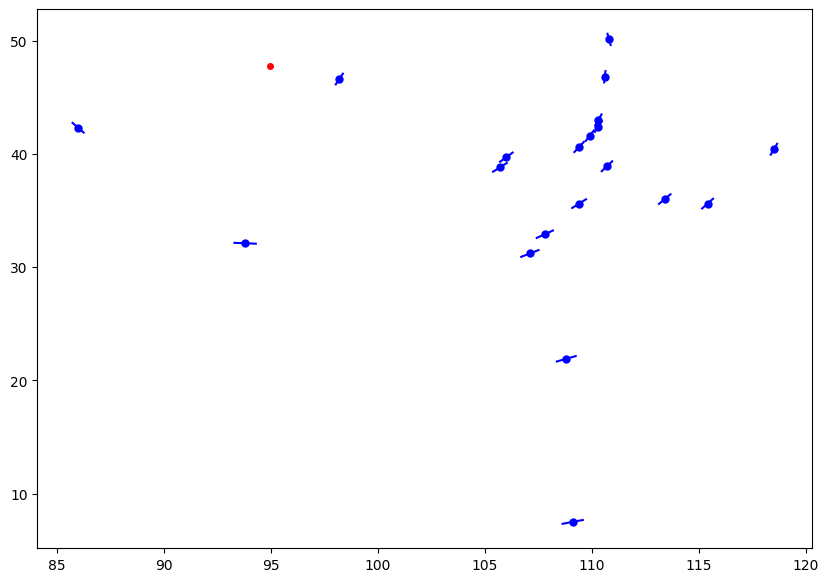

In [55]:
import math
def generate_player_intercepts(player_location: Point, shot_location: Point, offset: float):
    theta = math.atan2(shot_location.y - player_location.y, shot_location.x - player_location.x)
    # Rotation matrix
    offset_x = -offset * math.sin(theta)
    offset_y = offset * math.cos(theta)
    intercept_1 = Point(player_location.x + offset_x, player_location.y + offset_y)
    intercept_2 = Point(player_location.x - offset_x, player_location.y - offset_y)
    return intercept_1, intercept_2


row = df.iloc[0]
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

ax.plot([row.coordinates_x], [row.coordinates_y], color="red", marker="o", ms=4)
for player_data in row.freeze_frame:
    intercept_1, intercept_2 = generate_player_intercepts(
        Point(*player_data["location"]), Point(row.coordinates_x, row.coordinates_y), 0.5
    )
    ax.plot([player_data["location"][0]], [player_data["location"][1]], color="blue", marker="o", ms=5)
    ax.plot([intercept_1.x, intercept_2.x], [intercept_1.y, intercept_2.y], color="blue")

In [ ]:
def map_block_locations(
        shot_location: Point, blocker_location: Point, offset: float,
        goal_x: float = 120.
):
    shot_blocker_angle = math.atan2(
        blocker_location.y - shot_location.y, 
        blocker_location.x - shot_location.x
    )
    offset_x = -offset * math.sin(shot_blocker_angle)
    offset_y = offset * math.cos(shot_blocker_angle)
    offset_angle = math.atan2(
        offset_y - shot_location.y,
        offset_x - shot_location.x
    )
    offset_y_at_goal = shot_location.y + goal_x * math.tan(offset_angle)
    return offset_y_at_goal
    

In [ ]:
df.head()